In [3]:
!unzip datasetik_of_mine.zip

Archive:  datasetik_of_mine.zip
   creating: datasetik_of_mine/
   creating: datasetik_of_mine/Mahathir_Mohamad/
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0001.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0002.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0003.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0004.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0005.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0006.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0007.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0008.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0009.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0010.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mahathir_Mohamad_0011.jpg  
  inflating: datasetik_of_mine/Mahathir_Mohamad/Mah

In [1]:
# Крок 1: Вимкнути CUDA
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Крок 2: Встановлення залежностей
print("Встановлення залежностей...")
import sys
!pip install -q cmake dlib scikit-learn

Встановлення залежностей...


In [4]:
# Крок 3: Імпорт бібліотек
print("\nІмпорт бібліотек...")
import dlib
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from google.colab import files
import urllib.request
import bz2
import shutil
import time
import glob


Імпорт бібліотек...


In [5]:
# Крок 4: Автоматичне завантаження моделей dlib
print("\nЗавантаження моделей dlib...")

import os
import urllib.request
import bz2
import shutil

# Крок 4: Автоматичне завантаження моделей dlib
print("\nЗавантаження моделей dlib...")

def download_dlib_models(use_68_landmarks=False):
    """
    Автоматичне завантаження моделей dlib

    Args:
        use_68_landmarks: True = 68 точок, False = 5 точок (швидше)
    """
    # Вибрати модель landmarks
    if use_68_landmarks:
        landmark_model = 'shape_predictor_68_face_landmarks.dat'
        landmark_url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    else:
        landmark_model = 'shape_predictor_5_face_landmarks.dat'
        landmark_url = 'http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2'

    models = {
        landmark_model: landmark_url,
        'dlib_face_recognition_resnet_model_v1.dat':
            'http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2'
    }

    for model_name, url in models.items():
        if not os.path.exists(model_name):
            print(f"Завантаження {model_name}...")
            compressed_file = model_name + '.bz2'

            try:
                urllib.request.urlretrieve(url, compressed_file)

                print(f"Розпакування {model_name}...")
                with bz2.BZ2File(compressed_file) as fr, open(model_name, 'wb') as fw:
                    shutil.copyfileobj(fr, fw)

                os.remove(compressed_file)
                print(f"{model_name} готовий")

            except Exception as e:
                print(f"Помилка завантаження {model_name}: {e}")
                if os.path.exists(compressed_file):
                    os.remove(compressed_file)
        else:
            print(f"{model_name} вже існує")

# Завантажити 5-точкову модель (швидше)
download_dlib_models(use_68_landmarks=False)

# АБО завантажити 68-точкову модель (детальніше)
# download_dlib_models(use_68_landmarks=True)


Завантаження моделей dlib...
  Завантаження shape_predictor_68_face_landmarks.dat...
  Розпакування shape_predictor_68_face_landmarks.dat...
  shape_predictor_68_face_landmarks.dat готовий
  Завантаження dlib_face_recognition_resnet_model_v1.dat...
  Розпакування dlib_face_recognition_resnet_model_v1.dat...
  dlib_face_recognition_resnet_model_v1.dat готовий


In [6]:
# Крок 5: Ініціалізація моделей dlib
print("\nІніціалізація моделей dlib...")
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
face_encoder = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")
print("Моделі dlib завантажено (CPU режим)")

VALID_EXT = ['.png', '.jpg', '.jpeg']


Ініціалізація моделей dlib...
Моделі dlib завантажено (CPU режим)


In [16]:
# Крок 6: Клас для розпізнавання облич
class FaceRecognitionDlib:
    def __init__(self, threshold=0.6):
        self.threshold = threshold
        self.name_encodings_dist = {}

    def preprocess_image(self, img):
        if img is None:
            return None

        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

        denoised = cv2.fastNlMeansDenoisingColored(enhanced, None, 10, 10, 7, 21)
        return denoised

    def get_image_paths(self, root_dir, class_names=None):
        image_paths = []

        if not os.path.exists(root_dir):
            print(f"ПОМИЛКА: Папка {root_dir} не існує")
            return []

        if class_names is None:
            class_names = os.listdir(root_dir)

        for class_name in class_names:
            class_dir = os.path.sep.join([root_dir, class_name])

            if not os.path.isdir(class_dir):
                continue

            class_file_paths = glob.glob(os.path.sep.join([class_dir, '*.*']))

            for file_path in class_file_paths:
                ext = os.path.splitext(file_path)[1]
                if ext.lower() not in VALID_EXT:
                    continue
                image_paths.append(file_path)

        return image_paths

    def detect_faces(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        rects = face_detector(gray, 1)
        return rects

    def face_encodings(self, img, num_jitters=10):
        """Генерація енкодингів з нормалізацією"""
        rects = self.detect_faces(img)
        landmarks = [shape_predictor(img, rect) for rect in rects]

        encodings = [np.array(face_encoder.compute_face_descriptor(img, landmark, num_jitters))
                    for landmark in landmarks]

        if encodings:
            encodings = normalize(encodings, axis=1)

        return encodings, rects

    def train(self, root_dir, max_images=None):
        print(f"\nПочаток навчання...")
        class_names = os.listdir(root_dir)
        image_paths = self.get_image_paths(root_dir, class_names)

        if max_images:
            image_paths = image_paths[:max_images]

        print(f"Зображень для обробки: {len(image_paths)}")

        successful = 0
        failed = 0

        for idx, image_path in enumerate(image_paths, 1):
            if idx % 10 == 0 or idx == 1:
                print(f"Обробка зображення {idx}/{len(image_paths)}")

            try:
                image = cv2.imread(image_path)
                if image is None:
                    failed += 1
                    continue

                preprocessed = self.preprocess_image(image)
                encodings, _ = self.face_encodings(preprocessed)

                if len(encodings) > 0:
                    name = os.path.basename(os.path.dirname(image_path))
                    self.name_encodings_dist.setdefault(name, []).extend(encodings)
                    successful += 1
                else:
                    failed += 1

            except Exception as e:
                print(f"Помилка на {idx}: {e}")
                failed += 1

        # Конвертація в numpy arrays
        for name in self.name_encodings_dist:
            self.name_encodings_dist[name] = np.array(self.name_encodings_dist[name])

        print(f"\nНавчання завершено.")
        print(f"Успішно: {successful}/{len(image_paths)}")
        print(f"Помилок: {failed}/{len(image_paths)}")
        print(f"Осіб у базі: {len(self.name_encodings_dist)}")

    def save_encodings(self, filename="encodings_improved.pickle"):
        with open(filename, "wb") as f:
            pickle.dump(self.name_encodings_dist, f)
        print(f"Збережено: {filename}")

    def load_encodings(self, filename="encodings_improved.pickle"):
        with open(filename, "rb") as f:
            self.name_encodings_dist = pickle.load(f)
        print(f"Завантажено {len(self.name_encodings_dist)} осіб")

    def recognize(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            return None, [], [], []

        preprocessed = self.preprocess_image(image)
        encodings, rects = self.face_encodings(preprocessed)

        names = []
        confidences = []

        for encoding in encodings:
            best_match = "Unknown"
            best_distance = float('inf')

            for name, known_encs in self.name_encodings_dist.items():
                distances = np.linalg.norm(known_encs - encoding, axis=1)
                min_distance = np.min(distances)

                if min_distance < best_distance:
                    best_distance = min_distance
                    best_match = name

            if best_distance <= self.threshold:
                names.append(best_match)
                confidences.append(1 - best_distance)
            else:
                names.append("Unknown")
                confidences.append(0)

        return image, rects, names, confidences

    def show_results(self, image, rects, names, confidences):
        if image is None:
            return

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for rect, name, conf in zip(rects, names, confidences):
            x1, y1, x2, y2 = rect.left(), rect.top(), rect.right(), rect.bottom()
            color = (30, 255, 140) if name != "Unknown" else (255, 30, 30)
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 2)

            label = f"{name} ({conf:.2f})" if name != "Unknown" else name
            cv2.putText(image_rgb, label, (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        plt.figure(figsize=(10, 8))
        plt.imshow(image_rgb)
        plt.axis("off")
        plt.title("Dlib Face Recognition")
        plt.show()

print("Клас FaceRecognitionDlib створено")

Клас FaceRecognitionDlib створено


In [13]:
# === ПРИКЛАД 1: Використати LFW датасет ===
def use_lfw_dataset(min_faces=10, max_images=500):
    """Завантажити та обробити LFW датасет"""
    print("\nЗавантаження LFW датасету...")

    lfw_people = fetch_lfw_people(
        min_faces_per_person=min_faces,
        resize=1.0,
        color=True,
        download_if_missing=True
    )

    print(f"Завантажено {len(lfw_people.images)} зображень")
    print(f"Кількість осіб: {len(lfw_people.target_names)}")

    # Підготовка датасету
    train_dir = "lfw_dataset/train"
    os.makedirs(train_dir, exist_ok=True)

    print("\nЗбереження зображень...")
    for idx, (img, label) in enumerate(zip(lfw_people.images, lfw_people.target)):
        person_name = lfw_people.target_names[label]
        person_dir = os.path.join(train_dir, person_name)
        os.makedirs(person_dir, exist_ok=True)

        img_bgr = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        img_path = os.path.join(person_dir, f"{idx:04d}.jpg")
        cv2.imwrite(img_path, img_bgr)

    # Навчання
    recognizer = FaceRecognitionDlib(threshold=0.6)
    recognizer.train(train_dir, max_images=max_images)
    recognizer.save_encodings("lfw_encodings.pickle")

    return recognizer

# === ПРИКЛАД 2: Використати власний датасет ===
def use_custom_dataset(dataset_path):
    """Обробити власний датасет"""
    recognizer = FaceRecognitionDlib(threshold=0.6)
    recognizer.train(dataset_path)
    recognizer.save_encodings("custom_encodings.pickle")
    return recognizer

# === ПРИКЛАД 3: Тестувати власні зображення ===
def test_uploaded_images(recognizer):
    """Тестувати завантажені зображення"""
    print("\nЗавантажте зображення для тестування...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n{'='*60}")
        print(f"Обробка: {filename}")
        print('='*60)

        start_time = time.time()
        image, rects, names, confidences = recognizer.recognize(filename)
        elapsed = time.time() - start_time

        if image is None:
            print(f"Помилка завантаження {filename}")
            continue

        if not rects:
            print("Обличчя не знайдено")
            recognizer.show_results(image, [], [], [])
            continue

        print(f"Час обробки: {elapsed:.2f}s")
        print(f"Знайдено облич: {len(names)}")

        for i, (name, conf) in enumerate(zip(names, confidences), 1):
            if name != "Unknown":
                print(f"  Обличчя {i}: {name} (впевненість: {conf:.2%})")
            else:
                print(f"  Обличчя {i}: Невідома особа")

        recognizer.show_results(image, rects, names, confidences)

In [17]:
recognizer = use_custom_dataset('datasetik_of_mine')


Початок навчання...
Зображень для обробки: 318
Обробка зображення 1/318
Обробка зображення 10/318
Обробка зображення 20/318
Обробка зображення 30/318
Обробка зображення 40/318
Обробка зображення 50/318
Обробка зображення 60/318
Обробка зображення 70/318
Обробка зображення 80/318
Обробка зображення 90/318
Обробка зображення 100/318
Обробка зображення 110/318
Обробка зображення 120/318
Обробка зображення 130/318
Обробка зображення 140/318
Обробка зображення 150/318
Обробка зображення 160/318
Обробка зображення 170/318
Обробка зображення 180/318
Обробка зображення 190/318
Обробка зображення 200/318
Обробка зображення 210/318
Обробка зображення 220/318
Обробка зображення 230/318
Обробка зображення 240/318
Обробка зображення 250/318
Обробка зображення 260/318
Обробка зображення 270/318
Обробка зображення 280/318
Обробка зображення 290/318
Обробка зображення 300/318
Обробка зображення 310/318

Навчання завершено.
Успішно: 314/318
Помилок: 4/318
Осіб у базі: 47
Збережено: custom_encodings.pi


Завантажте зображення для тестування...


Saving Ali_test.jpg to Ali_test (1).jpg

Обробка: Ali_test (1).jpg
Час обробки: 3.22s
Знайдено облич: 1
  Обличчя 1: Muhammad_Ali (впевненість: 73.48%)


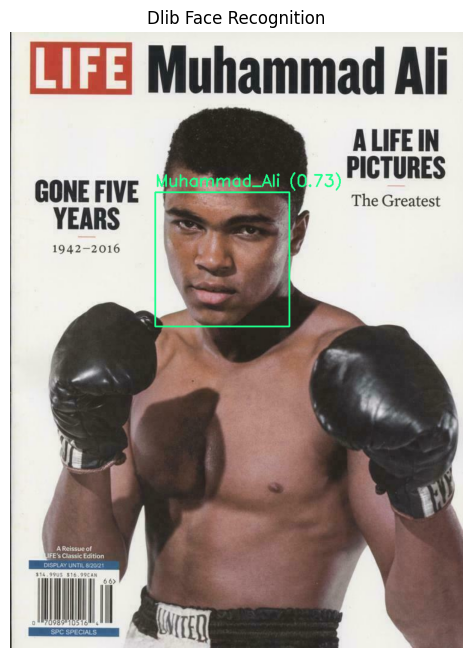

In [18]:
test_uploaded_images(recognizer)


Завантажте зображення для тестування...


Saving Tyson_test.jpg to Tyson_test (1).jpg

Обробка: Tyson_test (1).jpg
Час обробки: 2.76s
Знайдено облич: 1
  Обличчя 1: Mike_Tyson (впевненість: 68.86%)


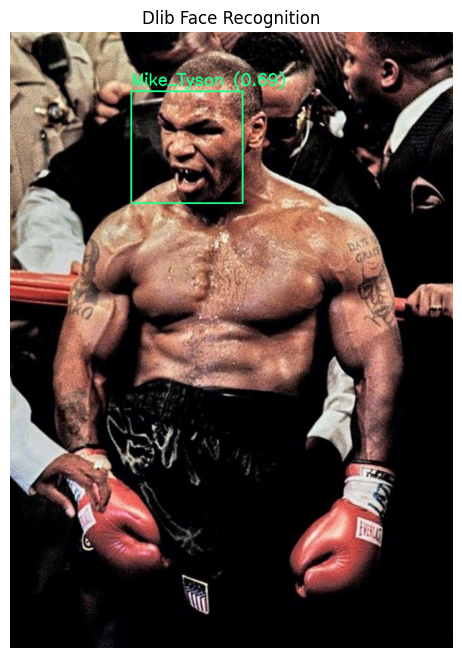

In [19]:
test_uploaded_images(recognizer)


Завантажте зображення для тестування...


Saving me_test.jpg to me_test (1).jpg

Обробка: me_test (1).jpg
Час обробки: 2.84s
Знайдено облич: 1
  Обличчя 1: Me (впевненість: 67.13%)


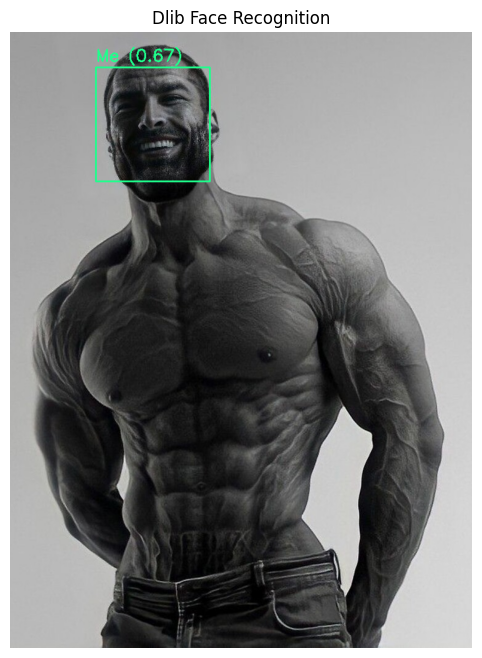

In [20]:
test_uploaded_images(recognizer)

In [ ]:
# Крок 5: Ініціалізація моделей dlib
print("\nІніціалізація моделей dlib...")
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor("shape_predictor_5_face_landmarks.dat")
face_encoder = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")
print("Моделі dlib завантажено (CPU режим)")

VALID_EXT = ['.png', '.jpg', '.jpeg']

In [ ]:
recognizer2 = use_custom_dataset('datasetik_of_mine')